In [1]:
%matplotlib inline
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

import datajoint as dj
from pipeline import rf, pre, psy

DataJoint 0.2.7 (June 30, 2016)
Loading local settings from /Users/dimitri/.datajoint_config.json


/Users/dimitri/dev/cajal-pipeline/python/pipeline/rf.py:17: UserWarning: OpenCV is not installed. You won't be able to populate rf.Eye
  warnings.warn("OpenCV is not installed. You won't be able to populate rf.Eye")
/Users/dimitri/dev/cajal-pipeline/python/pipeline/pre.py:17: UserWarning: c2s was not found. You won't be able to populate ExtracSpikes
  warn("c2s was not found. You won't be able to populate ExtracSpikes")


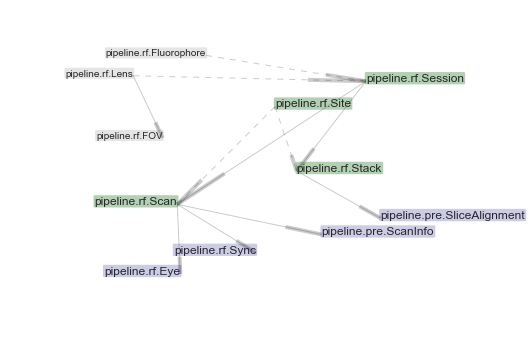

In [2]:
(dj.ERD(rf)+1).draw()

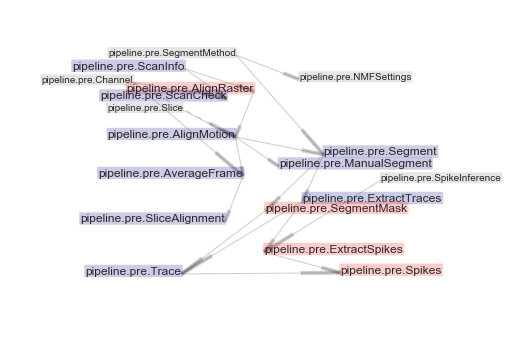

In [3]:
dj.ERD(pre).draw()

In [4]:
pre.AverageFrame().heading

# my newest table
animal_id            : int(11)                      # id (internal to database)
session              : smallint(6)                  # session index
scan_idx             : smallint(6)                  # number of TIFF stack file
slice                : tinyint(4)                   # slice number
channel              : tinyint(4)                   # channel number 1=green, 2=red'
---
frame                : longblob                     # motion aligned and computed as q-norm to approximate maximum projection

In [5]:
a = pre.AverageFrame() & 'animal_id=8623' & 'slice=3' & 'scan_idx=6' & 'channel=1'

In [6]:
pre.ScanInfo()

animal_id,session,scan_idx,nframes_requested,nframes,px_width,px_height,um_width,um_height,bidirectional,fps,zoom,dwell_time,nchannels,nslices,slice_pitch,fill_fraction
8341,1,4,27500,27500,256,256,400.0,400.0,1,14.6681,2.1,0.177018,2,3,7.0,0.712867
8341,1,6,26700,26700,256,256,400.0,400.0,1,14.6681,2.1,0.177018,2,3,7.0,0.712867
8341,1,7,26700,26700,256,256,400.0,400.0,1,14.6681,2.1,0.177018,2,3,7.0,0.712867
8341,1,8,26700,18000,256,256,400.0,400.0,1,14.6681,2.1,0.177018,2,3,7.0,0.712867
8341,1,9,26700,26700,256,256,400.0,400.0,1,14.6681,2.1,0.177018,2,3,7.0,0.712867
8341,1,10,26700,26700,256,256,400.0,400.0,1,14.6681,2.1,0.177018,2,3,7.0,0.712867
8341,1,11,26700,26700,256,256,400.0,400.0,1,14.6681,2.1,0.177018,2,3,7.0,0.712867


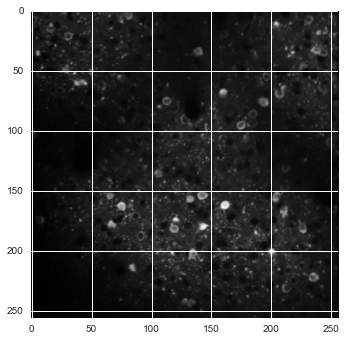

In [7]:
plt.imshow(a.fetch1['frame'], cmap=plt.cm.gray)

In [8]:
a = pre.Trace()*rf.Scan().proj('depth') & (rf.Sync() * psy.MovingNoise()) & 'depth>300' & 'slice=3'

In [9]:
@pre.schema
class Contrast(dj.Computed):
    definition = """
    -> AverageFrame
    --- 
    contrast : double   # fake quantity
    """
    
    def _make_tuples(self, key):
        frame = (pre.AverageFrame() & key).fetch1['frame']
        key['contrast'] = frame.max()/frame.min()
        self.insert1(key)
        print('.', end='', flush=True)

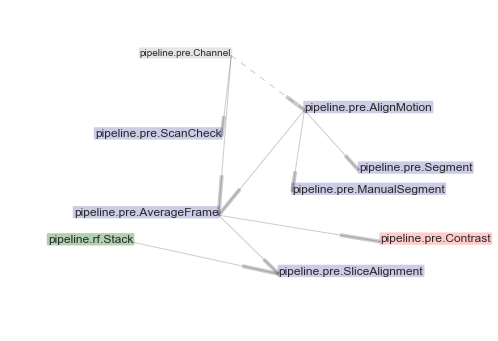

In [10]:
(dj.ERD(Contrast)-1+1-1+1).draw()

In [11]:
Contrast().populate('animal_id=8623', 'channel=1')

..............................

In [12]:
Contrast().progress();

Contrast             Completed 30 of 315 (9.5%)   2016-06-29 18:46:47


In [13]:
Contrast().progress('animal_id=8623', 'channel=1');

Contrast             Completed 30 of 30 (100.0%)   2016-06-29 18:46:48


In [14]:
Contrast()

animal_id,session,scan_idx,slice,channel,contrast
8623,1,2,1,1,70.354
8623,1,2,2,1,96.0056
8623,1,2,3,1,94.9282
8623,1,3,1,1,130.971
8623,1,3,2,1,125.281
8623,1,3,3,1,136.159
8623,1,5,1,1,126.998


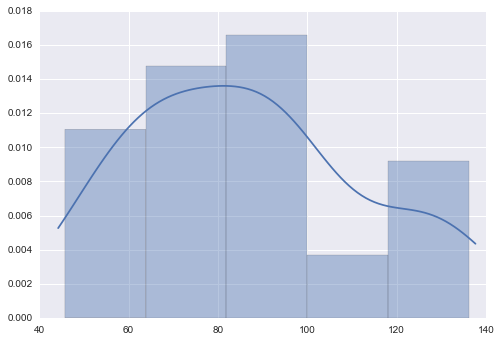

In [15]:
sns.distplot(Contrast().fetch['contrast'])

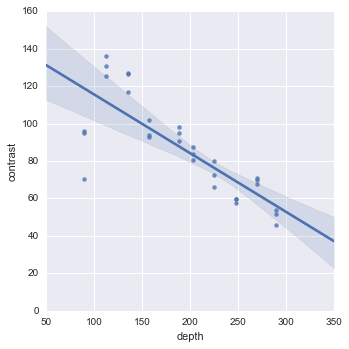

In [16]:
sns.lmplot('depth','contrast', data=pd.DataFrame((Contrast()*rf.Scan()).fetch()))

In [17]:
Contrast().drop()

`pipeline_preprocessing`.`__contrast` (30 tuples)
Proceed? [yes, No]: yes
Tables dropped.  Restart kernel.


In [18]:
pre.Trace()

animal_id,session,scan_idx,slice,segment_method,mask_id
8341,1,4,1,1,1
8341,1,4,1,1,2
8341,1,4,1,1,3
8341,1,4,1,1,4
8341,1,4,1,1,5
8341,1,4,1,1,6
8341,1,4,1,1,7


In [19]:
pre.Trace()*pre.Spikes()*rf.Sync()

animal_id,session,scan_idx,slice,segment_method,mask_id,spike_inference,psy_id,first_trial,last_trial,sync_ts
8341,1,4,1,1,1,2,2,2,31,2016-02-16 07:00:04
8341,1,4,1,1,1,3,2,2,31,2016-02-16 07:00:04
8341,1,4,1,1,2,2,2,2,31,2016-02-16 07:00:04
8341,1,4,1,1,2,3,2,2,31,2016-02-16 07:00:04
8341,1,4,1,1,3,2,2,2,31,2016-02-16 07:00:04
8341,1,4,1,1,3,3,2,2,31,2016-02-16 07:00:04
8341,1,4,1,1,4,2,2,2,31,2016-02-16 07:00:04


In [20]:
pre.Trace()*pre.Spikes()*rf.Sync() & psy.MovingNoise() & (rf.Scan() & 'depth>300') & 'slice=3' & 'spike_inference=3'

animal_id,session,scan_idx,slice,segment_method,mask_id,spike_inference,psy_id,first_trial,last_trial,sync_ts
8804,1,14,3,2,1,3,1,272,301,2016-03-04 10:12:01
8804,1,14,3,2,2,3,1,272,301,2016-03-04 10:12:01
8804,1,14,3,2,3,3,1,272,301,2016-03-04 10:12:01
8804,1,14,3,2,4,3,1,272,301,2016-03-04 10:12:01
8804,1,14,3,2,5,3,1,272,301,2016-03-04 10:12:01
8804,1,14,3,2,6,3,1,272,301,2016-03-04 10:12:01
8804,1,14,3,2,7,3,1,272,301,2016-03-04 10:12:01


In [21]:
a = pre.Trace()*pre.Spikes()*rf.Sync() & psy.MovingNoise() & (rf.Scan() & 'depth>300') & 'slice=3' & 'spike_inference=3'
a.heading

animal_id            : int(11)                      # id (internal to database)
session              : smallint(6)                  # session index
scan_idx             : smallint(6)                  # number of TIFF stack file
slice                : tinyint(4)                   # slice number
segment_method       : tinyint(4)                   # id of the method
mask_id              : int(11)                      # id of the mask
spike_inference      : tinyint(4)                   # spike inference method
---
ca_trace             : longblob                     # raw calcium trace
spike_trace          : longblob                     # 
psy_id               : smallint(5) unsigned         # unique psy session number
first_trial          : int(11)                      # first trial in recording
last_trial           : int(11)                      # last trial in recording
frame_times          : longblob                     # times of frames and slices
sync_ts="CURRENT_TIMESTAMP" : timestamp

In [22]:
a.make_sql()

'SELECT * FROM `pipeline_preprocessing`.`_trace` NATURAL JOIN `pipeline_preprocessing`.`__spikes` NATURAL JOIN `pipeline_rf`.`_sync` WHERE ((`animal_id`,`psy_id`) in (SELECT `animal_id`,`psy_id` FROM `common_psy`.`moving_noise`)) AND ((`animal_id`,`session`,`scan_idx`) in (SELECT `animal_id`,`session`,`scan_idx` FROM `pipeline_rf`.`scan` WHERE (depth>300))) AND (slice=3) AND (spike_inference=3)'

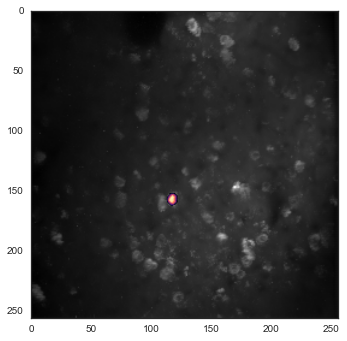

In [23]:
# fetch image and mask data for a single cell
a &= dict(mask_id=13, spike_inference=3)
mask = pre.AverageFrame() * pre.SegmentMask() & a & 'channel=1'
frame, mask_px, mask_w = mask.fetch1['frame','mask_pixels','mask_weights'] 

# plot image and mask 
with sns.axes_style('white'):
    fig, ax = plt.subplots()
img = frame.ravel()*np.NaN
img[mask_px.astype(int).squeeze()] = mask_w.squeeze()
img = img.reshape(frame.shape)
ax.imshow(np.sqrt(frame), cmap=plt.cm.get_cmap('gray'))
ax.imshow(img.T, alpha=1, cmap=plt.cm.get_cmap('magma'))


In [24]:
# fetch 
traces = np.hstack(a.fetch['ca_trace'])

# save 
pd.DataFrame(traces).to_csv('my_traces.csv',index=False)

<IPython.core.display.Javascript object>


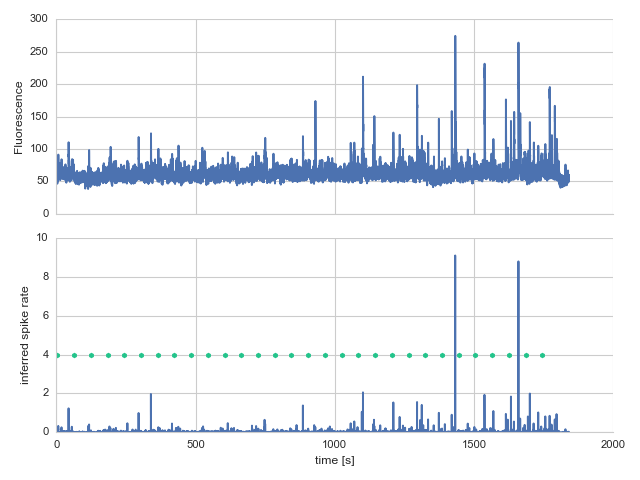

In [25]:
%matplotlib notebook

# fetch trace and trial data
times, traces, spikes = a.fetch1['frame_times', 'ca_trace','spike_trace']
trial_times = (psy.Trial() * a & 'trial_idx between first_trial and last_trial').fetch['flip_times']

# plot traces against time
trial_times = np.asarray([r[0,0] for r in trial_times])
with sns.axes_style('whitegrid'):
    fig, ax = plt.subplots(2,1, sharex=True)
ax[0].plot(times[0,::3]- times[0,0], traces, label='Ca Trace')
ax[1].plot(times[0,::3]- times[0,0], spikes, label='Spike Rate')
ax[0].set_ylabel('Fluorescence')
ax[1].set_ylabel('inferred spike rate')
ax[1].set_xlabel('time [s]')
ax[1].plot(trial_times - times[0,0], 0*trial_times+4,'h',color=sns.xkcd_rgb['greenblue'],ms=5)
sns.despine(fig)
fig.tight_layout()
